In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.utils_cy import approx_flux_likelihood_cy
from delight.photoz_gp import PhotozGP

In [2]:
# Load the parameter file and the useful quantities
%cd '/Users/bl/Dropbox/repos/PhotoZviaGP/'
params = parseParamFile('parameters.cfg', verbose=False)
params['training_catFile'] = '/Users/bl/Dropbox/repos/PhotoZviaGP/data/galaxies-fluxredshifts_small.txt'
params['target_catFile'] = '/Users/bl/Dropbox/repos/PhotoZviaGP/data/galaxies-fluxredshifts_small2.txt'
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
f_mod = readSEDs(params)
numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))
print('Number of Training Objects', numObjectsTraining)

/Users/bl/Dropbox/repos/PhotoZviaGP
Number of Training Objects 100


In [3]:
# Create the GP (create interpolation grid for kernel, and other internal stuff). May take a while.
gp = PhotozGP(f_mod, bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
              params['lines_pos'], params['lines_width'],
              params['V_C'], params['V_L'],
              params['alpha_C'], params['alpha_L'],
              redshiftGridGP, use_interpolators=True)

In [ ]:
# Load useful quantities for the training set.
bandIndicesCV, bandNamesCV, bandColumnsCV,\
    bandVarColumnsCV, redshiftColumnCV =\
    readColumnPositions(params, prefix="training_CV_", refFlux=False)
numBandsCV = bandIndicesCV.mbsize

In [57]:
# Adjust the extra error to be added in quadrature to all flux errors
# 1e-2 means 1% of the flux will be added to its error.
params['training_extraFracFluxError'] = 1e-2

In [58]:
# Loop and parse the training set, fit the GP to the deep bands, 
# and run cross-validation against the shallower SDSS bands
numZ = redshiftGrid.size
all_z = np.zeros((numObjectsTraining, ))
all_fluxes = np.zeros((numObjectsTraining, numBands))
all_fluxes_var = np.zeros((numObjectsTraining, numBands))
all_fluxesCV = np.zeros((numObjectsTraining, numBands))
all_fluxesCV_var = np.zeros((numObjectsTraining, numBands))
all_chi2s = np.zeros((numObjectsTraining, numBandsCV))
all_bestTypes = np.zeros((numObjectsTraining, ), dtype=int)

loc = - 1
trainingDataIter1 = getDataFromFile(params, 0, numObjectsTraining,
                                    prefix="training_", getXY=True,
                                    CV=True)
for z, normedRefFlux,\
    bands, fluxes, fluxesVar,\
    bandsCV, fluxesCV, fluxesVarCV,\
        X, Y, Yvar in trainingDataIter1:
    loc += 1

    # Interpolate template library at spectroscopic redshift
    themod = np.zeros((1, f_mod.shape[0], bands.size))
    for it in range(f_mod.shape[0]):
        for ib, band in enumerate(bands):
            themod[0, it, ib] = f_mod[it, band](z)
    # Run color likelihood to find best template and ML luminosity
    chi2_grid, ellMLs = scalefree_flux_likelihood(fluxes, fluxesVar, themod, returnChi2=True)
    bestType = np.argmin(chi2_grid)
    ell = ellMLs[0, bestType]
    # Use them in the GP
    X[:, 2] = ell
    gp.setData(X, Y, Yvar, bestType)
    
    # Make predictions for all bands (noiseless) from the GP
    model_mean, model_covar\
        = gp.predictAndInterpolate(np.array([z]), ell=ell)
    ind = np.array([list(bandIndicesCV).index(b) for b in bandsCV])
    # Compute chi2 for SDSS bands
    all_chi2s[loc, ind] =\
        (model_mean[0, bandsCV] - fluxesCV)**2 /\
        (model_covar[0, bandsCV] + fluxesVarCV)
        
    # Store a few useful quantities
    all_z[loc] = z
    all_bestTypes[loc] = bestType
    all_fluxes[loc, bands] = fluxes
    all_fluxes_var[loc, bands] = fluxesVar
    all_fluxesCV[loc, bandsCV] = fluxesCV
    all_fluxesCV_var[loc, bandsCV] = fluxesVarCV

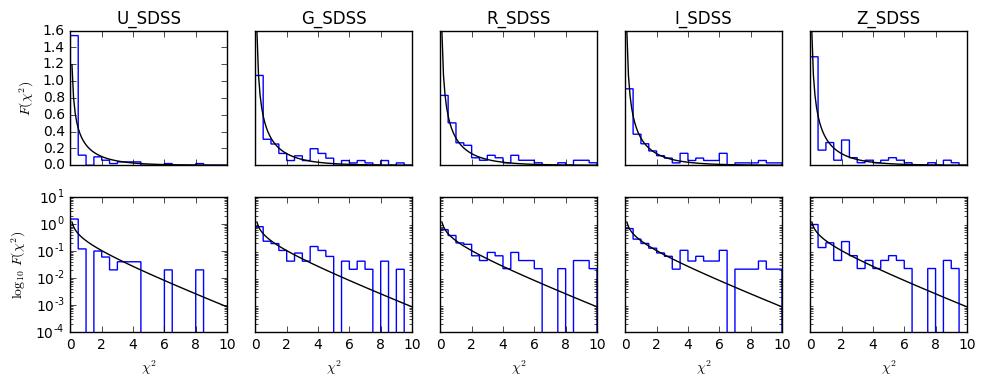

In [59]:
# Plot the chi2 distributions for each band (1 degree of freedom)
fig, axs = plt.subplots(2, 5, figsize=(10, 4), sharex=True)
x = np.linspace(0, 10, 100)
for i, ib in enumerate(bandsCV):    
    axs[0, i].plot(x, scipy.stats.chi2.pdf(x, 1), 'k')
    axs[0, i].hist(all_chi2s[:, i], 20, range=[0, x[-1]], histtype='step', normed=True, lw=1)
    axs[1, i].plot(x, scipy.stats.chi2.pdf(x, 1), 'k')
    axs[1, i].hist(all_chi2s[:, i], 20, range=[0, x[-1]], histtype='step', normed=True, lw=1)
    axs[1, i].set_yscale('log')
    axs[1, i].set_xlabel('$\chi^2$')
    axs[0, i].set_title(bandNames[ib])
    if i == 0:
        axs[0, i].set_ylabel('$F(\chi^2)$')
        axs[1, i].set_ylabel('$\log_{10}\ F(\chi^2)$')
    else:
        axs[0, i].set_yticks([])
        axs[1, i].set_yticks([])
fig.tight_layout()